# Imports

In [104]:
import geojson as gj
import matplotlib.pyplot as plt
import folium as fl
import geopandas as gpd
import json
import pandas as pd
import networkx as nx
import sys
sys.path.append('/Users/johanmasvie/programming/tiø4900/master_thesis')
import utils

# Loading the SciGRID data

In [105]:
# Load all the GeoDataFrames into one folium map
m = fl.Map(location=[60.0, 10.0], zoom_start=5)
fl.GeoJson('/Users/johanmasvie/programming/tiø4900/master_thesis/Scigrid_data/IGGIN_BorderPoints.geojson', name='Border Points', style_function=lambda x: {'color': 'red'}).add_to(m)
fl.GeoJson('/Users/johanmasvie/programming/tiø4900/master_thesis/Scigrid_data/IGGIN_Compressors.geojson', name='Compressors', style_function=lambda x: {'color': 'blue'}).add_to(m)
fl.GeoJson('/Users/johanmasvie/programming/tiø4900/master_thesis/Scigrid_data/IGGIN_EntryPoints.geojson', name='Entry Points', style_function=lambda x: {'color': 'green'}).add_to(m)
fl.GeoJson('/Users/johanmasvie/programming/tiø4900/master_thesis/Scigrid_data/IGGIN_InterConnectionPoints.geojson', name='InterConnection Points', style_function=lambda x: {'color': 'orange'}).add_to(m)
fl.GeoJson('/Users/johanmasvie/programming/tiø4900/master_thesis/Scigrid_data/IGGIN_LNGs.geojson', name='LNGs', style_function=lambda x: {'color': 'purple'}).add_to(m)
fl.GeoJson('/Users/johanmasvie/programming/tiø4900/master_thesis/Scigrid_data/IGGIN_Nodes.geojson', name='Nodes', style_function=lambda x: {'color': 'black'}).add_to(m)
fl.GeoJson('/Users/johanmasvie/programming/tiø4900/master_thesis/Scigrid_data/IGGIN_PipeSegments.geojson', name='Pipe Segments', style_function=lambda x: {'color': 'brown'}).add_to(m)
fl.GeoJson('/Users/johanmasvie/programming/tiø4900/master_thesis/Scigrid_data/IGGIN_Storages.geojson', name='Storages', style_function=lambda x: {'color': 'pink'}).add_to(m)
fl.LayerControl().add_to(m)

# Save the map
m.save('/Users/johanmasvie/programming/tiø4900/master_thesis/Scigrid_data/IGGIN_map.html')

# Data Exploration

## Nodes

In [106]:
# Load the file "/Users/johanmasvie/programming/tiø4900/master_thesis/Scigrid_data/IGGIN_Nodes.geojson" into a GeoDataFrame
nodes = gpd.read_file('/Users/johanmasvie/programming/tiø4900/master_thesis/Scigrid_data/IGGIN_Nodes.geojson')

# Print the first 5 rows of the GeoDataFrame
nodes.head()

,name,id,country_code,tags,param,method,geometry
0,N_0,NO_N_0,NO,{},"{'eic_code': None, 'elevation_m': None, 'exact...","{'eic_code': None, 'elevation_m': None, 'exact...",POINT (6.79720 65.10640)
1,N_1,NO_N_1,NO,{},"{'eic_code': None, 'elevation_m': None, 'exact...","{'eic_code': None, 'elevation_m': None, 'exact...",POINT (5.19357 59.33286)
2,N_2,NO_N_2,NO,{},"{'eic_code': None, 'elevation_m': None, 'exact...","{'eic_code': None, 'elevation_m': None, 'exact...",POINT (2.89575 60.56023)
3,N_3,NO_N_3,NO,{},"{'eic_code': None, 'elevation_m': None, 'exact...","{'eic_code': None, 'elevation_m': None, 'exact...",POINT (2.89614 60.78219)
4,N_4,NO_N_4,NO,{},"{'eic_code': None, 'elevation_m': None, 'exact...","{'eic_code': None, 'elevation_m': None, 'exact...",POINT (3.29837 54.78877)


## Pipelines

In [107]:
# Open the file: "/Users/johanmasvie/programming/tiø4900/master_thesis/Scigrid_data/IGGIN_PipeSegments.csv" as a GeoDataFrame: gdf
pipelines_gdf = gpd.read_file('/Users/johanmasvie/programming/tiø4900/master_thesis/Scigrid_data/IGGIN_PipeSegments.csv')

# Split the 'param' column into separate columns
pipelines_gdf['param'] = pipelines_gdf['param'].apply(lambda x: json.loads(x.replace("'", '"')))
param_df = pd.json_normalize(pipelines_gdf['param'])
pipelines_gdf = pipelines_gdf.drop(columns=['param']).join(param_df)

# Split the 'uncertainty' column into separate columns and add them to the GeoDataFrame, prefaced by the string 'uncertainty_'
pipelines_gdf['uncertainty'] = pipelines_gdf['uncertainty'].apply(lambda x: json.loads(x.replace("'", '"')))
uncertainty_df = pd.json_normalize(pipelines_gdf['uncertainty'])
uncertainty_df.columns = ['uncertainty_' + col for col in uncertainty_df.columns]
pipelines_gdf = pipelines_gdf.drop(columns=['uncertainty']).join(uncertainty_df)

# Split the 'method' column into separate columns and add them to the GeoDataFrame, prefaced by the string 'method_'
pipelines_gdf['method'] = pipelines_gdf['method'].apply(lambda x: json.loads(x.replace("'", '"')))
method_df = pd.json_normalize(pipelines_gdf['method'])
method_df.columns = ['method_' + col for col in method_df.columns]
pipelines_gdf = pipelines_gdf.drop(columns=['method']).join(method_df)

# Split the "country_code" column into two separate columns. "['ES', 'ES']" is an example of a value in the "country_code" column
pipelines_gdf['country_code'] = pipelines_gdf['country_code'].apply(lambda x: x.replace('[', '').replace(']', '').replace("'", '').split(', '))
country_code_df = pd.DataFrame(pipelines_gdf['country_code'].to_list(), columns=['country_code_1', 'country_code_2'])
pipelines_gdf = pipelines_gdf.drop(columns=['country_code']).join(country_code_df)

# Split the node_id column into two separate columns. "['INET_N_23', 'INET_N_295']" is an example of a value in the "node_id" column
pipelines_gdf['node_id'] = pipelines_gdf['node_id'].apply(lambda x: x.replace('[', '').replace(']', '').replace("'", '').split(', '))
node_id_df = pd.DataFrame(pipelines_gdf['node_id'].to_list(), columns=['node_id_1', 'node_id_2'])
pipelines_gdf = pipelines_gdf.drop(columns=['node_id']).join(node_id_df)

In [108]:
# Count the number of records where both 'is_bothDirection' is '1'
both_directions = pipelines_gdf[(pipelines_gdf['is_bothDirection'] == 1)]
print(both_directions)

                    id                               name         source_id  \
14          INET_PL_28                                BBL    ['INET_PL_28']   
78    INET_PL_141_EE_0                            Deudan0   ['INET_PL_141']   
79    INET_PL_141_EE_1                            Deudan1   ['INET_PL_141']   
80         INET_PL_144                        Deudan_Loop   ['INET_PL_144']   
143        INET_PL_253                     Interconnector   ['INET_PL_253']   
309        INET_PL_529                    Pitgam_Maldegem   ['INET_PL_529']   
369        INET_PL_639                  Stolberg_Eynatten   ['INET_PL_639']   
371   INET_PL_643_EE_0                               TAG0   ['INET_PL_643']   
372   INET_PL_643_EE_1                               TAG1   ['INET_PL_643']   
373   INET_PL_643_EE_2                               TAG2   ['INET_PL_643']   
374   INET_PL_643_EE_3                               TAG3   ['INET_PL_643']   
375   INET_PL_643_EE_4                              

In [109]:
# Count the number of records where 

## Creating a NetworkX graph and plotting it

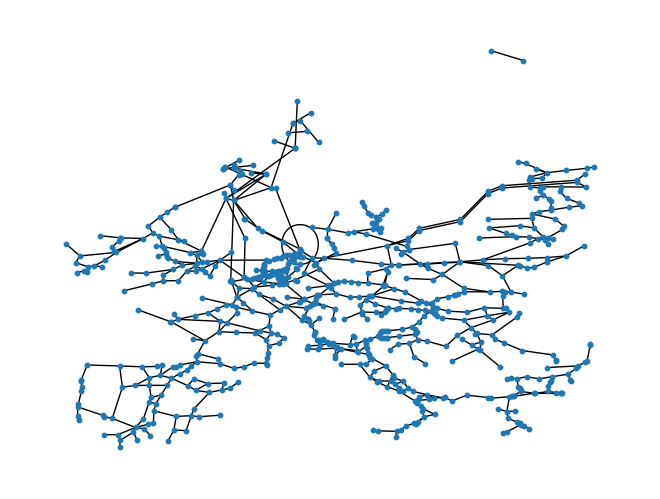

In [110]:
# Using the nodes GeoDataFrame, create a graph G. Use the "geometry" column to for the position of the nodes
G = nx.Graph()
for i, row in nodes.iterrows():
    G.add_node(row['id'], pos=(row['geometry'].x, row['geometry'].y))

# Using the pipelines GeoDataFrame, add edges to the graph G
for i, row in pipelines_gdf.iterrows():
    G.add_edge(row['node_id_1'], row['node_id_2'])

# Draw the graph G
pos = nx.get_node_attributes(G, 'pos')
nx.draw(G, pos, with_labels=False, node_size=10)
plt.show()

## Using matplotlib to plot the connected components

/var/folders/vr/0qryf_g13n11tpz1djg9ycb80000gn/T/ipykernel_31244/1942004062.py:14: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


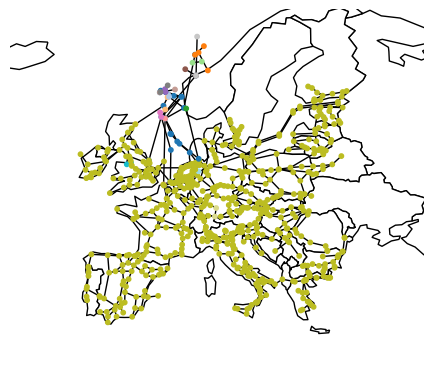

In [111]:
# Add a node attribute, representing the connected component each node belongs to
components = nx.connected_components(G)
component_of_node = {}
for i, component in enumerate(components):
    for node in component:
        component_of_node[node] = i

nx.set_node_attributes(G, component_of_node, 'component')

# Draw the graph G, with nodes colored by the component they belong to
node_color = [G.nodes[n]['component'] for n in G.nodes]

# Load a shapefile of Europe (you need to provide the path to the shapefile)
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Filter out the countries in Europe
europe = world[(world['continent'] == 'Europe')]

# Create a new figure
fig, ax = plt.subplots()

# Plot the map of Europe
europe.plot(ax=ax, color='white', edgecolor='black')

# Plot the graph G on top of the map of Europe
nx.draw(G, pos, ax=ax, with_labels=False, node_size=10, node_color=node_color, cmap='tab20')

# Show the plot, but only the part of the graph that is in Europe
plt.xlim(-20, 40)
plt.ylim(30, 70)
plt.show()


## Using folium to plot the connected components

In [112]:
# Create a folium map
m = fl.Map(location=[60.0, 10.0], zoom_start=5)

# Get the connected components
components = list(nx.connected_components(G))

# Create a color map
colors = ['red', 'blue', 'green', 'orange', 'purple', 'black', 'brown', 'pink']

# Iterate over the connected components
for i, component in enumerate(components):
    # Create a subgraph for the current component
    subgraph = G.subgraph(component)
    
    # Get the positions of the nodes in the subgraph
    pos = nx.get_node_attributes(subgraph, 'pos')
    
    # Draw the nodes
    for node, coordinates in pos.items():
        # Swap the latitude and longitude values
        coordinates = (coordinates[1], coordinates[0])
        fl.CircleMarker(
            location=coordinates,
            radius=5,
            color=colors[i % len(colors)],
            fill=True,
            fill_color=colors[i % len(colors)],
            fill_opacity=1.0,
        ).add_to(m)
    
    # Draw the edges
    for edge in subgraph.edges():
        # Swap the latitude and longitude values
        locations = [(pos[edge[0]][1], pos[edge[0]][0]), (pos[edge[1]][1], pos[edge[1]][0])]
        fl.PolyLine(locations=locations, color=colors[i % len(colors)]).add_to(m)

# Add a layer control element to the map
fl.LayerControl().add_to(m)

# Save the map to an HTML file
m